# TriathELOn Rankings

In [2]:
library(tidyverse)
library(gridExtra)
library(PlayerRatings)
source("../src/utils.R")

## Introduction
The aim of this analysis is to develop a new ranking system for elite triathletes competing on the [ITU triathlon](triathlon.org) World Triathlon Series, which is the top level of international triathlon competition. The ranking system is be an application of the famous [Glicko ranking system](http://glicko.net/glicko.html), most commonly used for international chess rankings. After the new ranking system is established, it will be tested against the ITU's internal ranking system to determine which is superior in terms of predictive power. Ideally, the end goal of this project is to use this ranking system to track athlete development, and backtrack athlete `podium pathways`.

## What is the Glicko rating system?
The Glicko rating system was created by Professor Mark Glickman to expand and improve upon the famous [Elo rating system](https://en.wikipedia.org/wiki/Elo_rating_system), which attempted to probabilistically rate chess players based on the results of their matches. In both the `Elo` and `Glicko` rating systems, each player is associated with a `Player Rating`, and the differences in Ratings between the two players is what drives the prediction for the outcome of a match. The larger the difference between two players, the higher the system will predict the stronger player's chances to win. After each match rating points are transferred from the losing player to the winning player in a zero sum fashion and both players ratings are updated. The pre match Rating differences between the two players is what determines the amount of Rating points transferred between the players. If one player was heavily favoured and won the match, then not a lot of Rating points are transferred (this match has not provided much additional information to the system), however for two closely ranked players, larger Ratings point changes will occur. <br><br>
The Glicko system expands upon the Elo system by adding a reliability measure to a players Rating, or RD (Ratings Deviation). In this way, players who have played more games and played more recently will have lower Ratings Deviations, and players who have not played in a long time will intuitively have higher Rating's Deviations. Additional information and examples about the `Glicko` formula can be found [here](http://www.glicko.net/glicko/glicko.pdf).

## Why Glicko Rating System for triathlon?
The International Triathlon Union has their own internal ranking system, where athletes accrue ranking points at the three levels of ITU competition (Continental Cups, World Cups, and World Triathlon Series), and are ranked according to their point totals. The amount of points an athlete earns are standardized based on the level of the event, with the winner of a Continental Cup earning $250$ points, a World Cup $500$ points, and a World Triathlon Series event $1000$ points. While the points given at are uniform at a given level or ace, the level of the competition you face is not. Some events are loaded with the top athletes, while for whatever reason, other races may be weak. It is because of these cases where I believe the Glicko ranking system will be a superior measure of an athletes ability than the ITU ranking system, as Ratings points are given out based solely on the quality of the athletes you race.   

## Adapting Glicko rating system to ITU triathlon
Both the Glicko and Elo rating systems were designed and derived with $2$-player zero sum games like chess in mind. To use the system in a triathlon context I will turn an $n$-person triathlon race into $(n)(n-1)/2$ individual `one-vs-one` races. There are a couple potential issues with this approach which will be discussed later. Additionally, a "ratings period" must be determined for each race, as in the Glicko system, the longer since a player has played their last game, the higher is their Ratings Deviation. Somewhat arbitrarily, during a WTS season I have set the difference between races to be "1 period" and the difference from the last race of a season and the first race of the next season to be "6 periods", so that periods roughly align with months passed. 

## Data 
The data used to construct the Ratings includes all WTS results from 2009 (when the WTS series was created) until the end of 2019, for both men and women. These results were accessed using [triathlon.org API](https://developers.triathlon.org/), but all results can also be downloaded via CSV from [triathlon.org results](https://triathlon.org/results). For each race, I create a dataframe of normal race results including all finishers, their places, times and their swim-bike-run splits. Additionally, in order to apply the `glicko` formula to an $n$ person triathlon race, I also created in a `one-vs-one` dataframe, with $n(n-1)/2$ rows, each row giving the result of the `one vs one` race between each pair of competitors.<br> 

Cleaned race-results, as well as the `one-vs-one` constructed dataframes, are included in the `data` directory, as well as the notebook showing how data was accessed and wrangled from the API.  Functions used in this process are included in the `src` directory. 

## WTS race history

| Season  | Races  | 
|--------|---|
| 2009   | Tongyeong, Madrid, Washington, Kitzbuehel, Hamburg, London, Yokohama, __Gold Coast__|   
| 2010   | Sydney, __Seoul__, Madrid, Hamburg, London, Kitzbuehel, __Budapest__| 
| 2011   | Sydney, Madrid, Kitzbuehel, Hamburg, London, Lausanne, __Beijing, Yokohama__|
| 2012   | Sydney, __San Diego, Madrid__, Kitzbuehel, Hamburg, Stockholm, __Yokohama__, Auckland|
| 2013   | Auckland, San Diego, Yokohama, Madrid, Kitzbuehel, Hamburg, Stockholm, London|
| 2014   | Auckland, Cape Town, Yokohama, London, Chicago, Hamburg, Stockholm, Edmonton|
| 2015   | Abu Dhabi, Auckland, Gold Coast, Cape Town, Yokohama, London, Hamburg, Stockholm, Edmonton, Chicago|
| 2016   | Abu Dhabi, Gold Coast, Cape Town, Yokohama, Leeds, Stockholm, Hamburg, Edmonton, Cozumel|
| 2017   | Abu Dhabi, Gold Coast, Yokohama, Leeds, Hamburg, Edmonton, Montreal, Stockholm, Rotterdam|
| 2018   | Abu Dhabi, Bermuda, Yokohama, Leeds, __HAMBURG__, Edmonton, Montreal, Gold Coast|
| 2019   | Abu Dhabi, Bermuda, Yokohama, Leeds, Montreal, Hamburg, __EDMONTON__, __LAUSANNE__|
<br>
__Bold font__: itu results do not have pre-race rankings <br>
__CAPS LOCK BOLD__: did not have results file in API call <br>



## Ranking metrics
In order to compare different ranking systems (`ITU` vs. `Glicko`),  some objective metrics are needed, and I used two different metrics,   `adjusted R-squared` and `Kendall's tau`.  The pre-race ranking of the athlete was used as the independent variable, and race result was used as the dependent variable. <br>
- The`R-squared` measure is widely used as measure of goodness of fit in a linear regression, and measures the proportion of variation in the dependent variable explained by the independent variable, with a measure of $0$ indicating no relationship, and a measure of $1.0$ indicating a perfect fit.
- `Kendall's tau` coefficient measures the ordinal relationship between two columns. To compare two "pre-race rankings", one can calculate a `Kendall's tau` coefficient between each ranking and the final race results, and see which ranking system has a higher coefficient. A `Kendall's tau` of 0 indicates no relationship, and a `Kendall's tau` value of 1 indicates a perfect relationship. 

The formula for `Kendall's tau` is as follows:

$$\text{kendall's tau} = \frac{\text{number of concordant pairs - number of discordant pairs}}{\text{total number of pairs}}$$

For example, the vectors $[1,2,3]$ and $[1,3,2]$ would have a `Kendall's tau` coefficient of $\frac{1}{3}, calculated as:<br>


$$
\frac{2 - 1}{3} = 0.333
$$

## Parameters of the Glicko model
I used the `PlayerRatings` [R package](https://cran.r-project.org/web/packages/PlayerRatings/PlayerRatings.pdf) in order to implement the Glicko algorithm. The model has a few parameters which needed to be set or learned, specified below.
- __Initial value of players__
    - For new players entering the system, they are given the default values from the `PlayerRatings` package of a Rating of $1500$, and a Rating Deviation of $350$. In the first race, everyone is new and all start with this rating, but as the season and years progress the number of new racers entering with the default Rating decreases. 
- __Uncertainty parameter c__
    - In the `glicko` formula, the ratings deviation of a player will decrease with every performance gathered from them, and the ratings deviation of a player will increase the greater period of time since their last performance. The parameter `c` is governs the increase in uncertainty between ratings periods.
    - To determine the optimal level of `c` was chosen via Grid search. At each level of `c`, the model is trained over the full time period, with the `R^2` being calculated for each race. The average `R^2` across the full $10$ years is recorded. The level of c is chosen by the arg. max of average `R^2`
    
__Process to determine the optimal value of c__<br>

- for each level of C
    - for each race in the dataset<br>
        - update race results dataframe with previous Glicko rankings, and rank athletes according to their Glicko rankings
        - determine Kendall's tau correlation between Glicko rankings and their finish results
        - determine R^2 between Glicko rankings and their finish results
        - use the results of the race to appropriately update the Glicko rankings
        
## Read in data

In [3]:
# calendar of all events included
calendar <- list("2009" = c("Tongyeong", "Madrid", "DC", "Kitzbuehel", "Hamburg", "London", "Yokohama", "Coast"),
                 "2010" = c("Sydney", "Seoul", "Madrid", "Hamburg", "London", "Kitzbuehel", "Budapest"),
                "2011" = c("Sydney", "Madrid", "Kitzbuehel", "Hamburg", "London", "Championships", "Beijing", "Yokohama"),
                "2012" = c("Sydney", "Diego", "Madrid", "Kitzbuehel", "Hamburg", "Stockholm", "Yokohama", "Auckland"),
                "2013" = c("Auckland", "Diego", "Yokohama", "Madrid", "Kitzbuehel", "Hamburg", "Stockholm", "London"),
                "2014" = c("Auckland", "Town", "Yokohama", "London", "Chicago", "Hamburg", "Stockholm", "Edmonton"),
                "2015" = c("Dhabi", "Auckland", "Coast", "Town", "Yokohama", "London", "Hamburg", "Stockholm", "Edmonton", "Chicago"),
                "2016" = c("Dhabi", "Coast", "Town", "Yokohama", "Leeds", "Stockholm", "Hamburg", "Edmonton", "Cozumel"),
                "2017" = c("Dhabi", "Coast", "Yokohama", "Leeds", "Hamburg", "Edmonton", "Montreal", "Stockholm", "Rotterdam"),
                "2018" = c("Dhabi", "Bermuda", "Yokohama", "Leeds", "Edmonton", "Montreal", "Coast"),
                "2019" = c("Dhabi", "Bermuda", "Yokohama", "Leeds", "Montreal", "Hamburg"))

# import all events and "ovo" df  from the CSV
male_races <- read_races(calendar, "male")
female_races <- read_races(calendar, "female")

### Find optimal `C`: male and female

In [4]:
### Find optimal level of C, grid to search over
c_vec <- seq(2, 20, by=2)

# find best value of c by grid-search function
# warnings are due to collinearity in first race where all players have
# ranking 1500
best_c_male <- suppressWarnings(find_best_c(c_vec, male_races))
best_c_female <- suppressWarnings(find_best_c(c_vec, female_races))

print(best_c_male)
print(best_c_female)

[1] 4
[1] 12


## Comparing glicko rankings to ITU rankings
Now that the optimal `c` level has been found to be $4$ for men, and $12$ for women, we can compare the two ranking systems (`ITU` rankings and `Glicko` rankings) in terms of their explanatory power. To do this, the process will be similar to above, except now we are working with a fixed value of `c`, and we are also calculating the `kendall's tau` and `adjusted R^2` for the `ITU` ranking system. The process followed is: <br><br>

- for each race in the dataset<br>
    - update race results dataframe with previous Glicko Rating, and rank athletes according to their Glicko Player Rating
    - determine `Kendall's tau` correlation and $R^2$ between Glicko rankings and finish results
    - determine `Kendall's tau` correlation and $R^2$ between ITU rankings and finish results
    - use the results of the race to appropriately update the Glicko Player Ratings
<br><br>
- The above algorithm is implemented in the `compare_rankings` function.

## Compare systems

In [5]:
male_summary <- compare_rankings(male_races, best_c_male)
female_summary <- compare_rankings(female_races, best_c_female)

Warning message in summary.lm(lm(race_gl$position ~ race_gl$glicko_rank)):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(lm(race_gl$position ~ race_gl$glicko_rank)):
“essentially perfect fit: summary may be unreliable”


## Plots and summary stats

To compare the results of the two methods, I will show the yearly average `Kendall's tau` as well as `R-squared` coefficient for both methods in each of the last $7$ years of the dataset ($2013-2019$). I do not perform these direct comparisons on the $2009-2012$ seasons, as in these seasons ITU pre race rankings are missing for $1-2$ races per year.

In [33]:
# vector to append year of race to each score
year_vec <- c(rep(2009, length(calendar$'2009')), 
              rep(2010, length(calendar$'2010')), 
              rep(2011, length(calendar$'2011')), 
              rep(2012, length(calendar$'2012')),
              rep(2013, length(calendar$'2013')), 
              rep(2014, length(calendar$'2014')), 
              rep(2015, length(calendar$'2015')), 
              rep(2016, length(calendar$'2016')),
              rep(2017, length(calendar$'2017')), 
              rep(2018, length(calendar$'2018')), 
              rep(2019, length(calendar$'2019')))

### Male results

In [34]:
# get summary stats for males
summary_stats(male_summary, year_vec)

metric,mean_metric
<chr>,<dbl>
r2_glicko,0.3289912
r2_itu,0.3030495
tau_glicko,0.4225098
tau_itu,0.3996381


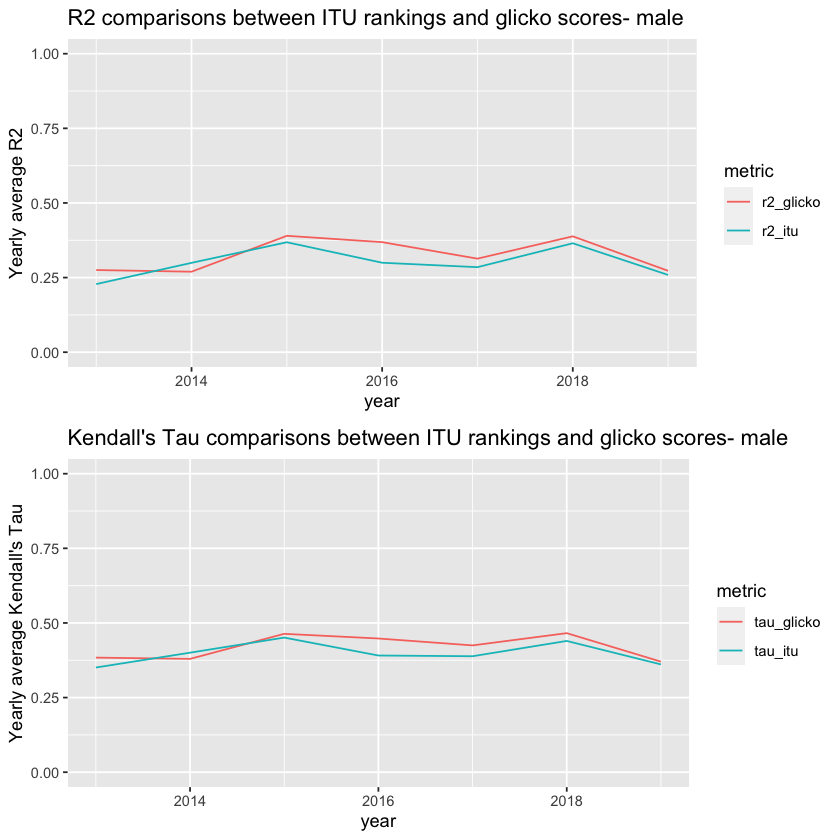

In [37]:
# plots for males
options(repr.plot.width = 7, repr.plot.height = 7)
rankings_over_time(male_summary, "male", year_vec)

### Female results

In [39]:
# get summary stats for males
summary_stats(female_summary, year_vec)

metric,mean_metric
<chr>,<dbl>
r2_glicko,0.3691012
r2_itu,0.3243317
tau_glicko,0.4499057
tau_itu,0.4165276


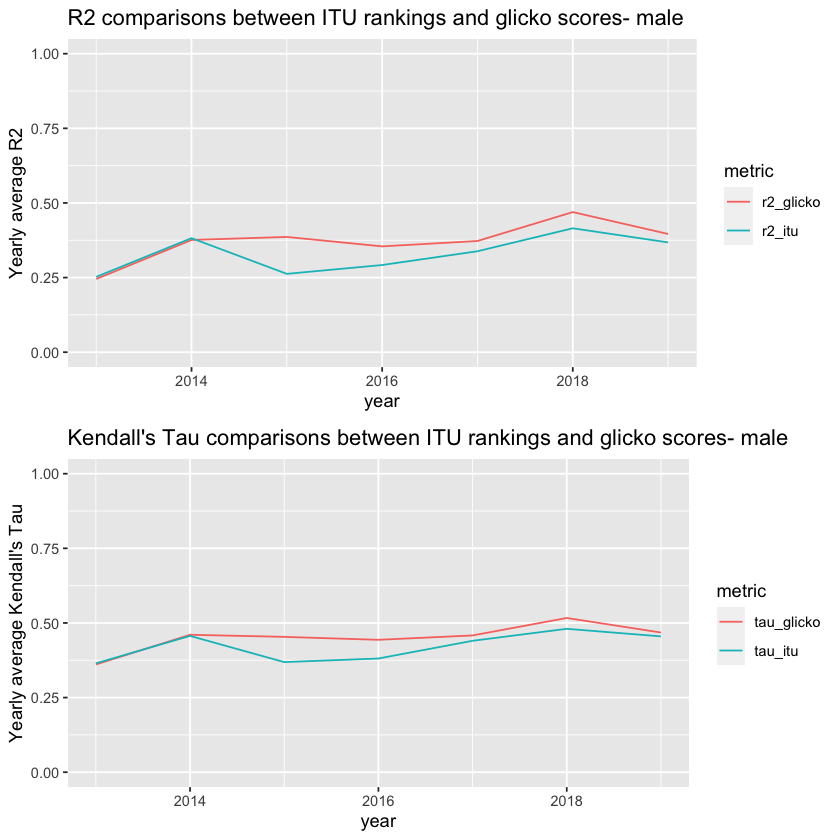

In [42]:
# plots for females
# plots for males
options(repr.plot.width = 7, repr.plot.height = 7)
rankings_over_time(female_summary, "male", year_vec)

## Discussion of results
In all four comparisons (`Kendalls Tau` and `R^2` for both men and women), the `Glicko` rankings outperform the `ITU` rankings by a couple of percentage points. This can be seen through the overall averages, as well as on the yearly average plots, where `Glicko` consistently slightly outperforms the `ITU` rankings. 
It appears that adapting the `Glicko` ranking formula to an n-player competition such as ITU triathlon may provide a better measure to rank athletes, and may be a viable ranking metric to use for tracking athlete development, and learning about podium pathways.